#### By: Peyman Shahidi
#### Created: Aug 21, 2025

<br>

In [195]:
#Python
import getpass
import numpy as np
import pandas as pd
from collections import defaultdict
import itertools
import random 

## formatting number to appear comma separated and with two digits after decimal: e.g, 1000 shown as 1,000.00
pd.set_option('float_format', "{:,.2f}".format)

import matplotlib.pyplot as plt
#%matplotlib inline
#from matplotlib.legend import Legend

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 200)

In [196]:
main_folder_path = ".."
input_data_path = f"{main_folder_path}/data"
output_data_path = f'{input_data_path}/computed_objects'
output_plot_path = f"{main_folder_path}/writeup/plots"

In [197]:
# Create directories if they don't exist
import os

for path in [output_data_path, output_plot_path]:
    if not os.path.exists(path):
        os.makedirs(path)

In [198]:
# Read O*NET data
onet = pd.read_csv(f'{input_data_path}/onet_occupations_yearly.csv')

# keep 2023 entries only
onet = onet[onet['year'] == 2023].reset_index(drop=True)

# define industry column:
# 2-digit SOC code --> Major Group
# 5-digit SOC code --> Minor Group
# 6-digit SOC code --> Broad Occupation
# 7-digit SOC code --> Detailed Occupation
SOC_group_num_digits = 5
onet['ind'] = onet['occ_code'].apply(lambda x: x[:SOC_group_num_digits])

# remove 's for consistency issues 
onet = onet.applymap(lambda x: x.replace("'", "") if isinstance(x, str) else x)

In [199]:
def merge_SOC_titles(df, occupation_string):
    # Assume column occupation_string contains the string of occupation identifier in df

    occLength_SOCcolumn_mapping = {
        2: 'Major Group',
        5: 'Minor Group',
        6: 'Broad Occupation',
        7: 'Detailed Occupation'
    }

    industry_column_entry_length = len(df[occupation_string].iloc[0]) # take the length of first entry
    soc_col_name = occLength_SOCcolumn_mapping[industry_column_entry_length]

    # Read SOC groups and derive 2 digit codes (from https://www.onetcenter.org/taxonomy/2019/structure.html)
    soc_group_df = pd.read_csv(f'{input_data_path}/SOC_Structure.csv')
    soc_group_df = soc_group_df[[soc_col_name, 'SOC or O*NET-SOC 2019 Title']]
    soc_group_df = soc_group_df.rename(columns={soc_col_name: 'ind',
                                                'SOC or O*NET-SOC 2019 Title': 'ind_name'
                                                })

    # Prepare dataset for the merge
    soc_group_df = soc_group_df.dropna() # Drop rows with NaN in 'ind' or 'ind_name' -- has to be included due to structure of "SOC_Structure.csv"
    soc_group_df['ind'] = soc_group_df['ind'].apply(lambda x: x[:industry_column_entry_length])

    # Merge datasets
    merged_df = pd.merge(df, soc_group_df, left_on=occupation_string, right_on='ind', how='left')

    return merged_df

# Merge O*NET data with SOC titles
onet = merge_SOC_titles(onet, 'ind')

In [200]:
# remove duplicates
print(f"Number of rows before removing duplicates: {len(onet)}")
onet = onet.drop_duplicates(subset=['year', 'ind', 'occ_code', 'task_id']).reset_index(drop=True)
print(f"Number of rows after removing duplicates: {len(onet)}")


############################################################################################
################## There's a lot of duplicates that you have to look into ##################
############################################################################################

Number of rows before removing duplicates: 24426
Number of rows after removing duplicates: 19294


In [201]:
# # Remove rows where occupation title contains "All Other"
# onet = onet[~onet["occ_title"].str.contains("All Other", case=False, na=False)]

### Remove "Teachers"-related occupations

In [202]:
# Filter rows that contain "Teachers" (case-insensitive)
contains_teacher = onet[onet['occ_title'].str.contains('Teachers', case=False, na=False)]

# Step 2: Get the number of unique occupations containing "Teacher"
unique_teacher_occupations = contains_teacher['occ_title'].nunique()
print(f'Number of unique occupations containing the word "Teachers": {unique_teacher_occupations}')

# Remove rows that contain "Teacher" (case-insensitive)
onet = onet[~onet['occ_title'].str.contains('Teachers', case=False, na=False)].reset_index(drop=True)

Number of unique occupations containing the word "Teachers": 50


### Number of Unique Tasks / DWAs / WAs

In [203]:
# Number of unique tasks, DWAs, and WAs
num_unique_tasks = onet['task_id'].nunique()
num_unique_dwas = onet['dwa_id'].nunique()
num_unique_was = onet['wa_id'].nunique()

print(f"Number of unique tasks: {num_unique_tasks}")
print(f"Number of unique DWAs: {num_unique_dwas}")
print(f"Number of unique WAs: {num_unique_was}")

Number of unique tasks: 17945
Number of unique DWAs: 2067
Number of unique WAs: 37


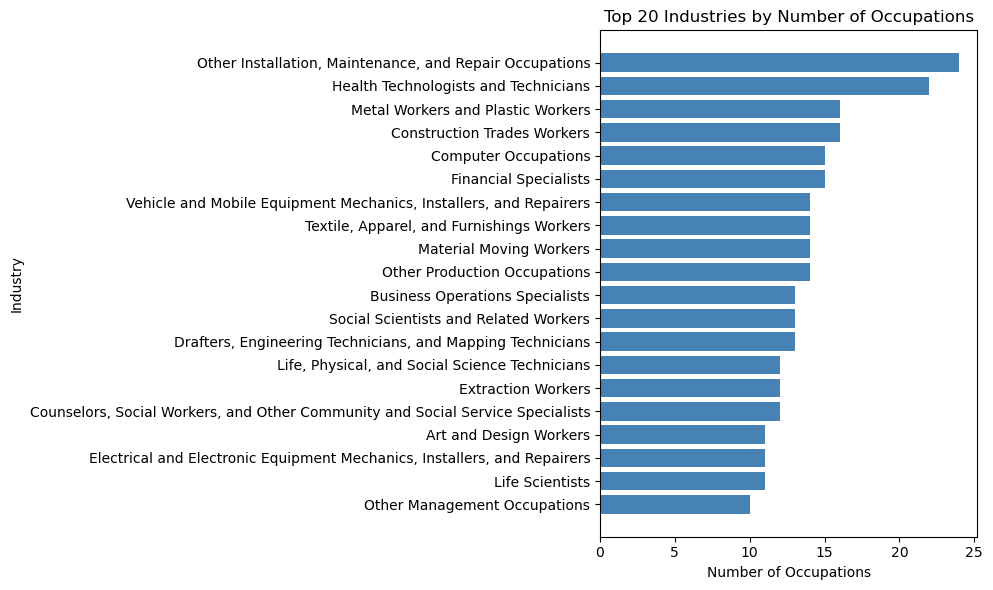

In [204]:
# 1. Number of occupations per industry
occ_per_ind = (
    onet.groupby("ind_name")["occ_title"]
    .nunique()
    .reset_index(name="num_occupations")
    .sort_values("num_occupations", ascending=False)
)

# Save results
occ_per_ind.to_csv(f'{output_data_path}/occupations_per_industry.csv', index=False)

# Plot (top 20 industries)
plt.figure(figsize=(10, 6))
plt.barh(
    occ_per_ind["ind_name"].head(20)[::-1],  # reverse for largest on top
    occ_per_ind["num_occupations"].head(20)[::-1],
    color="steelblue"
)
plt.title("Top 20 Industries by Number of Occupations")
plt.xlabel("Number of Occupations")
plt.ylabel("Industry")
plt.tight_layout()
plt.savefig(f'{output_plot_path}/occupations_per_industry.png')
plt.show()

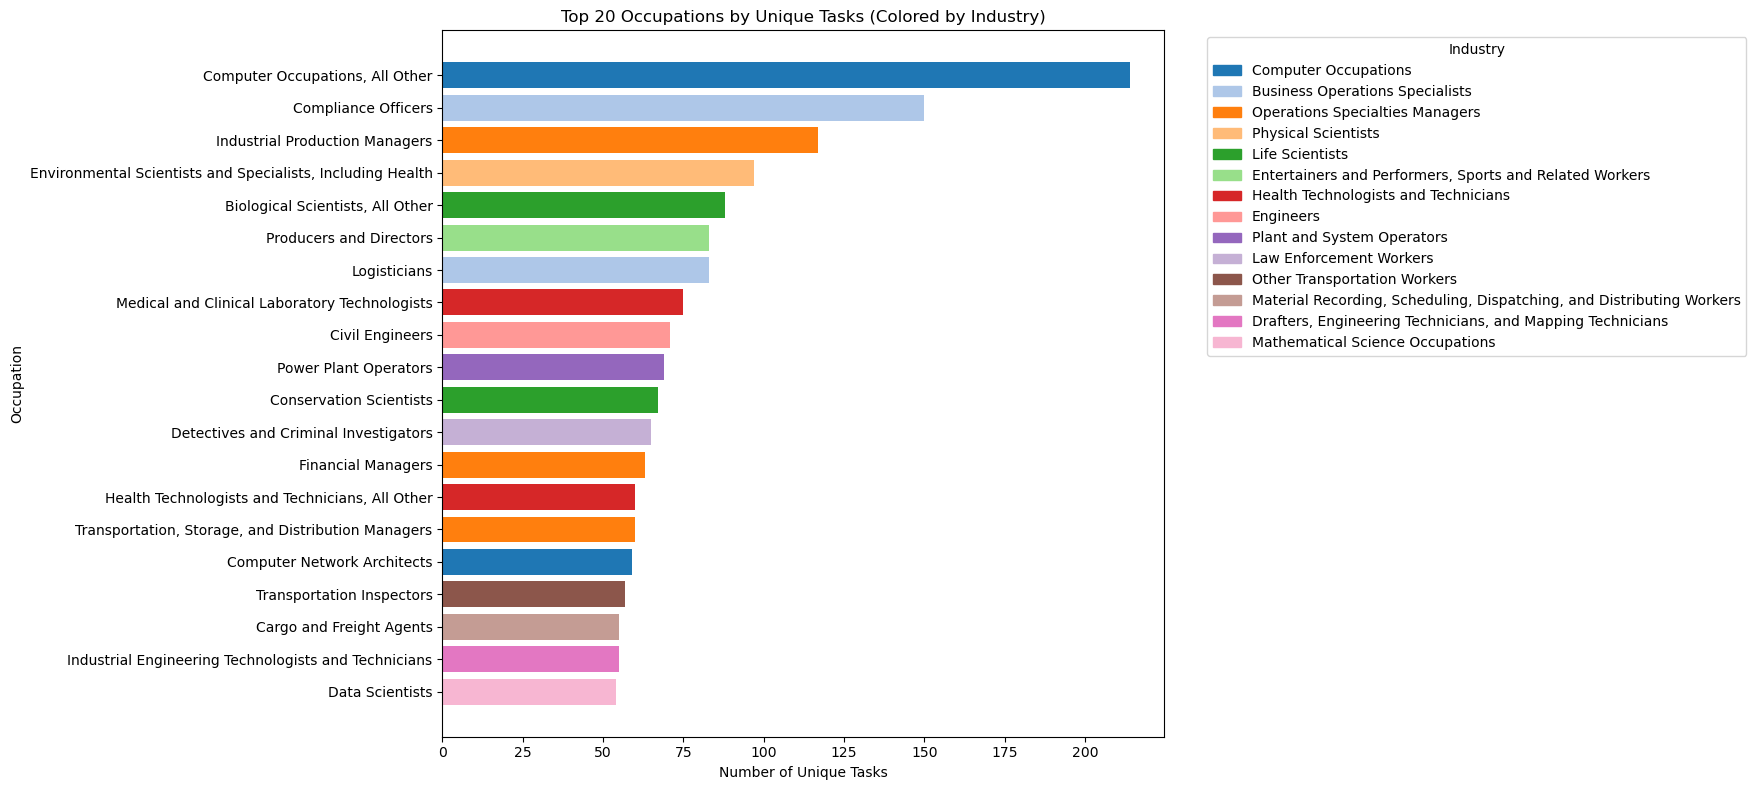

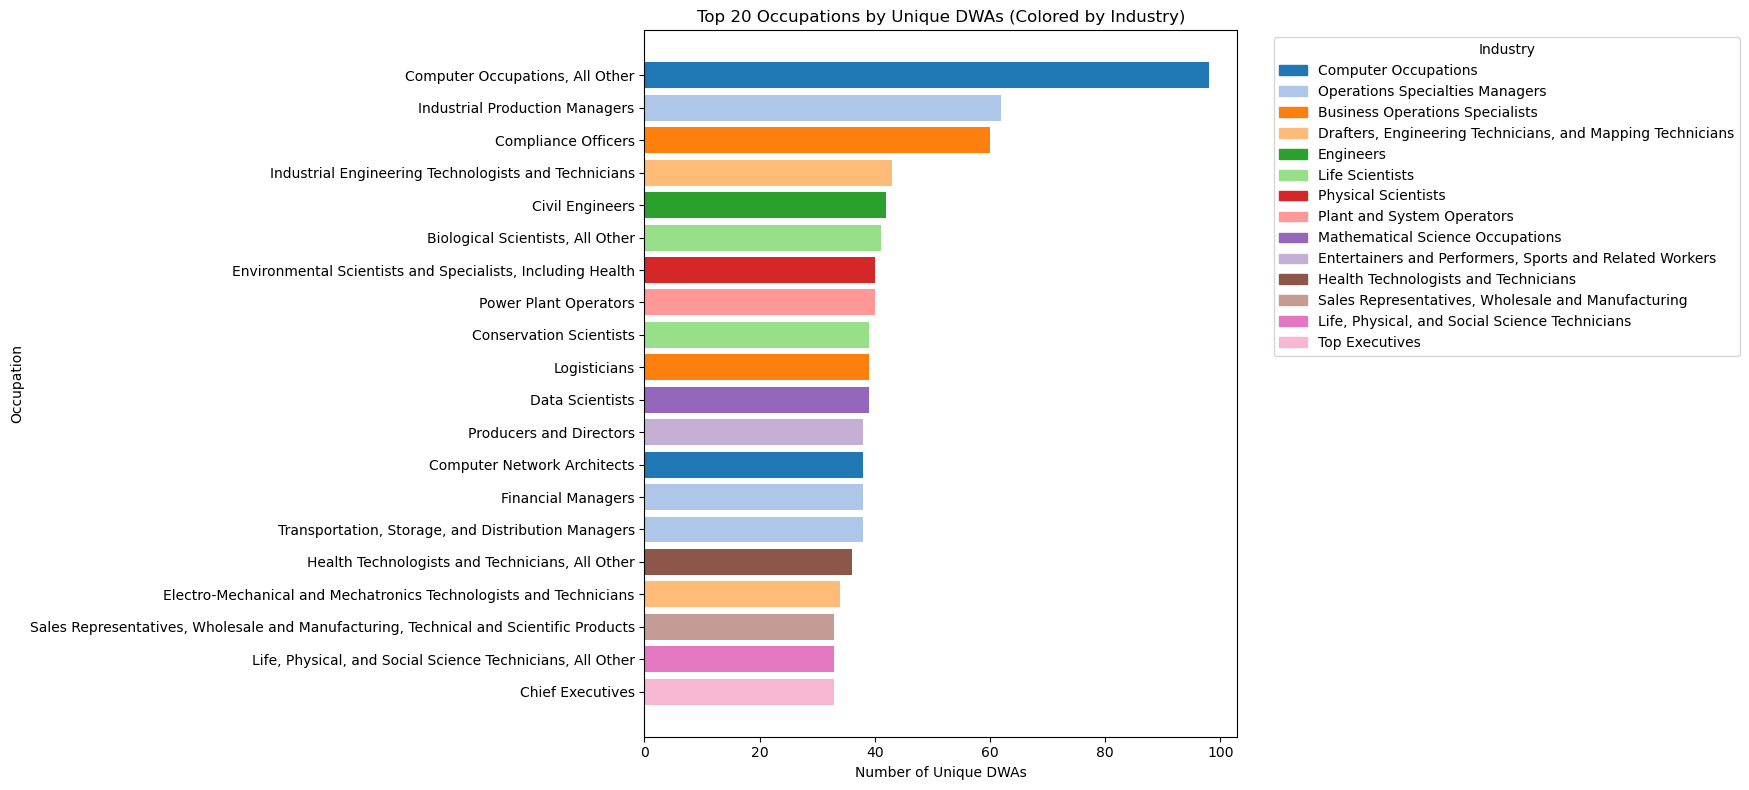

In [205]:
# 2. Number of unique tasks/DWAs/WAs per occupation
tasks_per_occ = (
    onet.groupby(['ind_name', "occ_title"])[["task", "dwa_title", "wa_name"]]
    .nunique()
    .reset_index()
    .rename(columns={
        "task": "num_unique_tasks",
        "dwa_title": "num_unique_DWAs",
        "wa_name": "num_unique_WAs"
    })
)

# Save results
tasks_per_occ.to_csv(f'{output_data_path}/unique_tasks_per_occupation.csv', index=False)


# ---- Plot 1: Top 20 occupations by tasks ----
top20_tasks = tasks_per_occ.sort_values("num_unique_tasks", ascending=False).head(20).copy()

plt.figure(figsize=(18, 8))

industries = top20_tasks["ind_name"].unique()
colors = plt.cm.tab20.colors
color_map = {ind: colors[i % len(colors)] for i, ind in enumerate(industries)}

y_labels = top20_tasks["occ_title"].iloc[::-1]
x_vals   = top20_tasks["num_unique_tasks"].iloc[::-1]
inds     = top20_tasks["ind_name"].iloc[::-1]

bars = plt.barh(y_labels, x_vals, color=[color_map[ind] for ind in inds])

plt.title("Top 20 Occupations by Unique Tasks (Colored by Industry)")
plt.xlabel("Number of Unique Tasks")
plt.ylabel("Occupation")

legend_patches = [plt.Rectangle((0,0),1,1, color=color_map[ind]) for ind in industries]
plt.legend(legend_patches, industries, title="Industry", 
           bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.savefig(f"{output_plot_path}/unique_tasks_per_occupation_by_industry.png")
plt.show()


# ---- Plot 2: Top 20 occupations by DWAs ----
top20_dwas = tasks_per_occ.sort_values("num_unique_DWAs", ascending=False).head(20).copy()

plt.figure(figsize=(18, 8))

industries = top20_dwas["ind_name"].unique()
colors = plt.cm.tab20.colors
color_map = {ind: colors[i % len(colors)] for i, ind in enumerate(industries)}

y_labels = top20_dwas["occ_title"].iloc[::-1]
x_vals   = top20_dwas["num_unique_DWAs"].iloc[::-1]
inds     = top20_dwas["ind_name"].iloc[::-1]

bars = plt.barh(y_labels, x_vals, color=[color_map[ind] for ind in inds])

plt.title("Top 20 Occupations by Unique DWAs (Colored by Industry)")
plt.xlabel("Number of Unique DWAs")
plt.ylabel("Occupation")

legend_patches = [plt.Rectangle((0,0),1,1, color=color_map[ind]) for ind in industries]
plt.legend(legend_patches, industries, title="Industry", 
           bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.savefig(f"{output_plot_path}/unique_dwas_per_occupation_by_industry.png")
plt.show()

In [206]:
# import numpy as np
# import matplotlib.pyplot as plt

# # --- Compute absolute counts per industry ---
# jobs_tasks_abs = (
#     onet.groupby("ind_name")
#     .agg(
#         num_unique_occ=("occ_title", "nunique"),
#         num_unique_tasks=("task", "nunique"),
#         num_unique_DWAs=("dwa_title", "nunique"),
#         num_unique_WAs=("wa_name", "nunique"),
#     )
#     .reset_index()
# )

# # Normalize values within each measure
# normed = jobs_tasks_abs.copy()
# normed["occ_norm"]   = normed["num_unique_occ"]   / normed["num_unique_occ"].max()
# normed["tasks_norm"] = normed["num_unique_tasks"] / normed["num_unique_tasks"].max()
# normed["DWAs_norm"]  = normed["num_unique_DWAs"]  / normed["num_unique_DWAs"].max()
# normed["WAs_norm"]   = normed["num_unique_WAs"]   / normed["num_unique_WAs"].max()

# # Sort industries by number of occupations (or whichever measure you prefer)
# normed = normed.sort_values("num_unique_occ", ascending=False)

# # --- Grouped bar plot (normalized, with raw counts as labels) ---
# ind = np.arange(len(normed))  # y positions
# bar_height = 0.2

# fig, ax = plt.subplots(figsize=(14, 0.6 * len(normed)))

# bars_occ  = ax.barh(ind - bar_height*1.5, normed["occ_norm"],   height=bar_height, color="steelblue", label="Occupations")
# bars_task = ax.barh(ind - bar_height*0.5, normed["tasks_norm"], height=bar_height, color="seagreen",  label="Tasks")
# bars_dwa  = ax.barh(ind + bar_height*0.5, normed["DWAs_norm"],  height=bar_height, color="darkorange",label="DWAs")
# bars_wa   = ax.barh(ind + bar_height*1.5, normed["WAs_norm"],   height=bar_height, color="purple",    label="WAs")

# # Labels and ticks
# ax.set_yticks(ind)
# ax.set_yticklabels(normed["ind_name"])
# ax.invert_yaxis()
# ax.set_title("Normalized Counts of Occupations, Tasks, DWAs, and WAs per Industry")
# ax.set_xlabel("Normalized Value (relative to max within each measure)")
# ax.legend()

# # Annotate bars with real (unnormalized) counts
# for bars, vals in [
#     (bars_occ,  normed["num_unique_occ"]),
#     (bars_task, normed["num_unique_tasks"]),
#     (bars_dwa,  normed["num_unique_DWAs"]),
#     (bars_wa,   normed["num_unique_WAs"]),
# ]:
#     for bar, val in zip(bars, vals):
#         ax.text(bar.get_width() + 0.005,  # offset so it doesn't overlap
#                 bar.get_y() + bar.get_height()/2.5,
#                 str(val), va="center", fontsize=8)

# plt.tight_layout()
# plt.savefig(f"{output_plot_path}/jobs_tasks_dwas_was_absolute_normalized.png")
# plt.show()

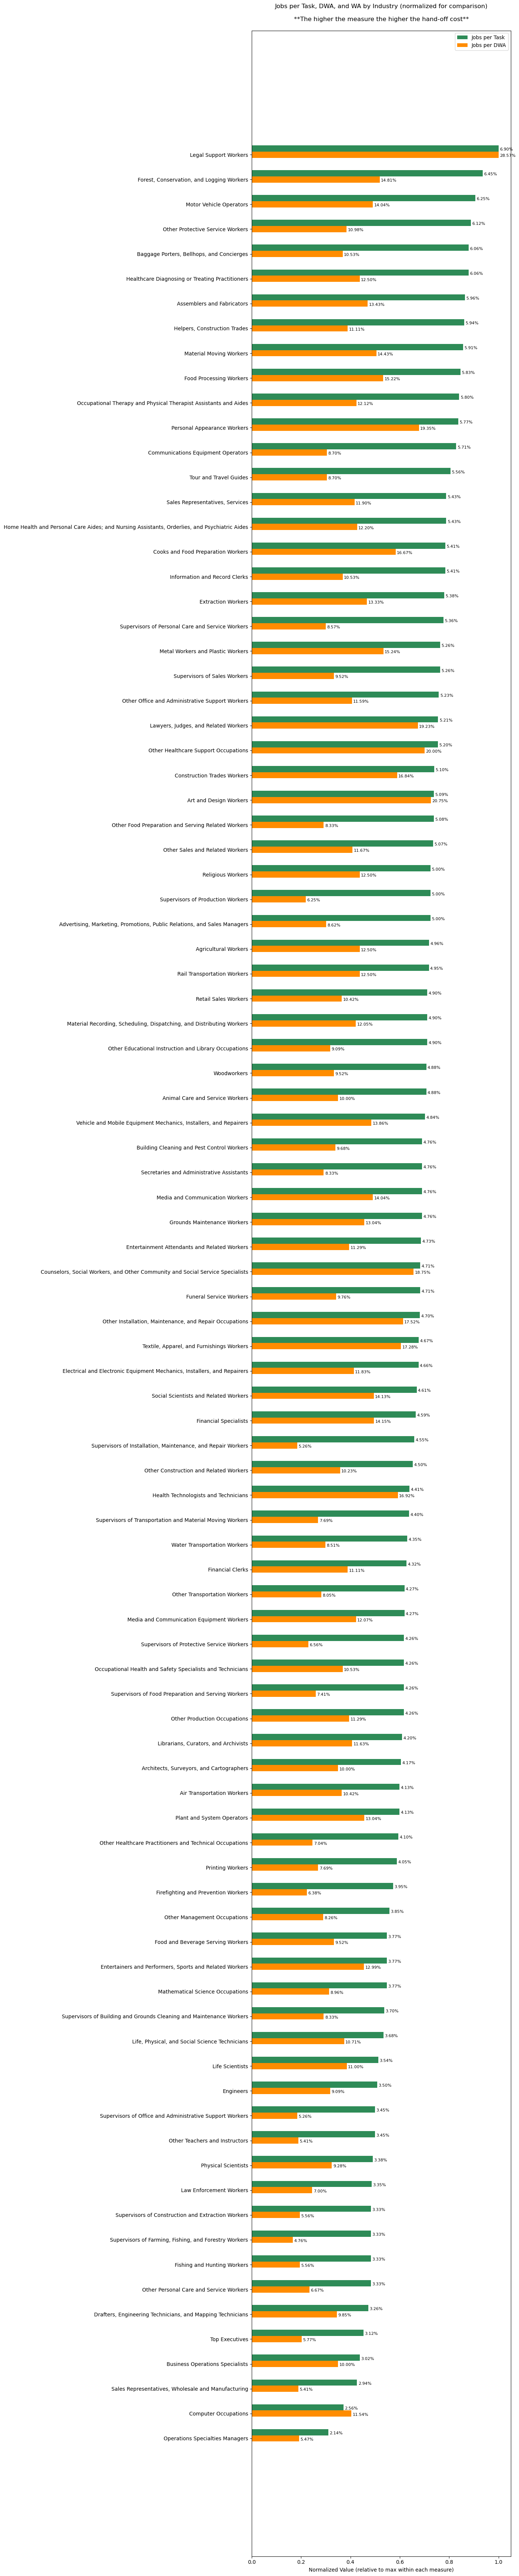

In [207]:
import numpy as np
import matplotlib.pyplot as plt

# --- Compute measure as before ---
jobs_tasks_ratio = (
    onet.groupby("ind_name")
    .agg(
        num_unique_occ=("occ_title", "nunique"),
        num_unique_tasks=("task", "nunique"),
        num_unique_DWAs=("dwa_title", "nunique"),
        num_unique_WAs=("wa_name", "nunique"),
    )
    .reset_index()
)

# Ratios (as percentages)
jobs_tasks_ratio["jobs_per_task"] = (
    jobs_tasks_ratio["num_unique_occ"] / jobs_tasks_ratio["num_unique_tasks"] * 100
)
jobs_tasks_ratio["jobs_per_DWA"] = (
    jobs_tasks_ratio["num_unique_occ"] / jobs_tasks_ratio["num_unique_DWAs"] * 100
)
jobs_tasks_ratio["jobs_per_WA"] = (
    jobs_tasks_ratio["num_unique_occ"] / jobs_tasks_ratio["num_unique_WAs"] * 100
)

# Sort industries by jobs_per_task (main metric)
jobs_tasks_ratio = jobs_tasks_ratio.sort_values("jobs_per_task", ascending=False)

# --- Normalize values for plotting ---
normed = jobs_tasks_ratio.copy()
normed["jobs_per_task_norm"] = normed["jobs_per_task"] / normed["jobs_per_task"].max()
normed["jobs_per_DWA_norm"]  = normed["jobs_per_DWA"]  / normed["jobs_per_DWA"].max()
normed["jobs_per_WA_norm"]   = normed["jobs_per_WA"]   / normed["jobs_per_WA"].max()

# --- Grouped bar plot ---
ind = np.arange(len(normed))  # y positions
bar_height = 0.25

fig, ax = plt.subplots(figsize=(14, 0.75 * len(normed)))

# Bars
bars_task = ax.barh(ind - bar_height, normed["jobs_per_task_norm"], height=bar_height, color="seagreen", label="Jobs per Task")
bars_dwa  = ax.barh(ind, normed["jobs_per_DWA_norm"], height=bar_height, color="darkorange", label="Jobs per DWA")
# bars_wa   = ax.barh(ind + bar_height, normed["jobs_per_WA_norm"], height=bar_height, color="purple", label="Jobs per WA")

# Labels and ticks
ax.set_yticks(ind)
ax.set_yticklabels(normed["ind_name"])
ax.invert_yaxis()  # highest values at top
ax.set_title("Jobs per Task, DWA, and WA by Industry (normalized for comparison)\n\n**The higher the measure the higher the hand-off cost**\n")
ax.set_xlabel("Normalized Value (relative to max within each measure)")
ax.legend()

# Annotate bars with real (unnormalized) values
for bars, vals in [
    (bars_task, normed["jobs_per_task"]),
    (bars_dwa, normed["jobs_per_DWA"]),
    # (bars_wa, normed["jobs_per_WA"]),
]:
    for bar, val in zip(bars, vals):
        ax.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/1.5,
                f"{val:.2f}%", va="center", fontsize=8)

plt.tight_layout()
plt.savefig(f"{output_plot_path}/jobs_per_task_dwa_wa_grouped_normalized.png")
plt.show()

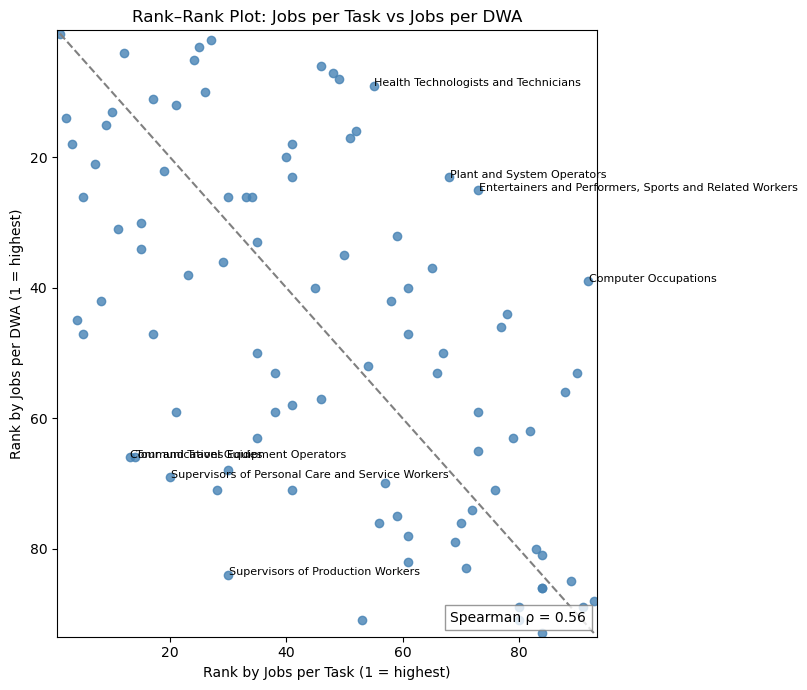

In [208]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# --- Compute measures (reuse your pipeline if already available) ---
jobs_tasks_ratio = (
    onet.groupby("ind_name")
    .agg(
        num_unique_occ=("occ_title", "nunique"),
        num_unique_tasks=("task", "nunique"),
        num_unique_DWAs=("dwa_title", "nunique"),
        num_unique_WAs=("wa_name", "nunique"),
    )
    .reset_index()
)

# Ratios (%)
jobs_tasks_ratio["jobs_per_task"] = (
    jobs_tasks_ratio["num_unique_occ"] / jobs_tasks_ratio["num_unique_tasks"] * 100
)
jobs_tasks_ratio["jobs_per_DWA"] = (
    jobs_tasks_ratio["num_unique_occ"] / jobs_tasks_ratio["num_unique_DWAs"] * 100
)

# --- Rank each industry on both metrics (1 = best/highest) ---
# method='min' keeps integer ranks when ties happen (e.g., 1,1,3,...)
ranks = jobs_tasks_ratio.copy()
ranks["rank_task"] = ranks["jobs_per_task"].rank(method="min", ascending=False).astype(int)
ranks["rank_dwa"]  = ranks["jobs_per_DWA"].rank(method="min", ascending=False).astype(int)

# Rank difference (to spot mismatches)
ranks["rank_diff"] = (ranks["rank_task"] - ranks["rank_dwa"]).abs()

# --- Plot rank–rank scatter ---
fig, ax = plt.subplots(figsize=(8, 7))

ax.scatter(ranks["rank_task"], ranks["rank_dwa"], color="steelblue", alpha=0.8)

# Axes labels/titles
ax.set_xlabel("Rank by Jobs per Task (1 = highest)")
ax.set_ylabel("Rank by Jobs per DWA (1 = highest)")
ax.set_title("Rank–Rank Plot: Jobs per Task vs Jobs per DWA")

# 45° reference line (perfect agreement)
max_rank = int(max(ranks["rank_task"].max(), ranks["rank_dwa"].max()))
ax.plot([1, max_rank], [1, max_rank], linestyle="--", color="gray")

# Put best ranks (1) near origin and increase down/right
ax.set_xlim(0.5, max_rank + 0.5)
ax.set_ylim(0.5, max_rank + 0.5)
ax.invert_yaxis()  # optional: top-left is "best-best"
# (If you prefer bottom-left as best-best, remove invert_yaxis())

# --- Label biggest mismatches to highlight “top in one ≠ top in the other” ---
# Adjust N to taste
N = min(8, len(ranks))
outliers = ranks.sort_values("rank_diff", ascending=False).head(N)
for _, row in outliers.iterrows():
    ax.text(row["rank_task"] + 0.1, row["rank_dwa"] + 0.1, row["ind_name"],
            fontsize=8, color="black")

# Optional: Spearman rank correlation (agreement in ordering)
spearman = ranks[["rank_task", "rank_dwa"]].corr(method="spearman").iloc[0,1]
ax.text(0.98, 0.02, f"Spearman ρ = {spearman:.2f}",
        transform=ax.transAxes, ha="right", va="bottom",
        fontsize=10, bbox=dict(facecolor="white", edgecolor="gray", alpha=0.8))

plt.tight_layout()
plt.savefig(f"{output_plot_path}/rank_rank_jobs_per_task_vs_dwa.png")
plt.show()

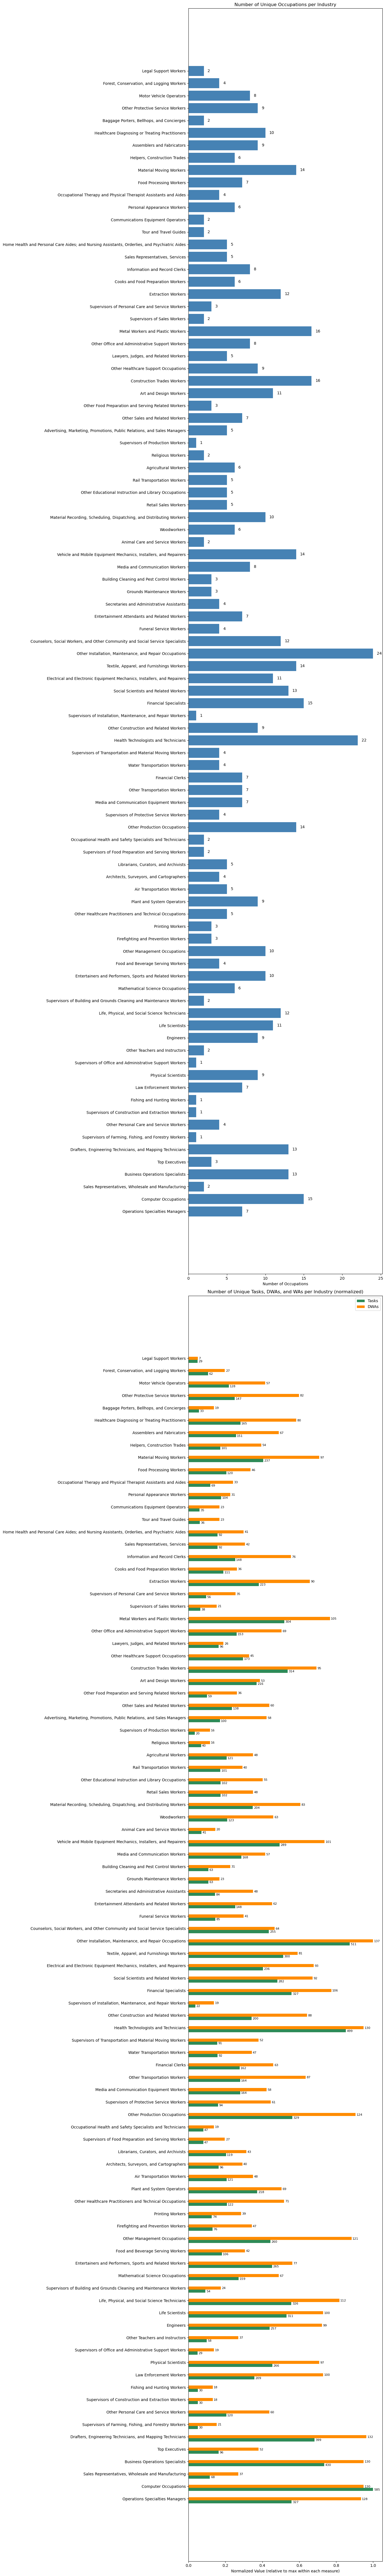

In [209]:
import numpy as np
import matplotlib.pyplot as plt

# --- Compute measure as before ---
jobs_tasks_ratio = (
    onet.groupby("ind_name")
    .agg(
        num_unique_occ=("occ_title", "nunique"),
        num_unique_tasks=("task", "nunique"),
        num_unique_DWAs=("dwa_title", "nunique"),
        num_unique_WAs=("wa_name", "nunique"),
    )
    .reset_index()
)

jobs_tasks_ratio["jobs_per_task"] = (
    jobs_tasks_ratio["num_unique_occ"] / jobs_tasks_ratio["num_unique_tasks"]
)

# Sort industries by jobs_per_task
jobs_tasks_ratio = jobs_tasks_ratio.sort_values("jobs_per_task", ascending=True)

# --- Normalize for grouped plot ---
normed = jobs_tasks_ratio.copy()
normed["tasks_norm"] = normed["num_unique_tasks"] / normed["num_unique_tasks"].max()
normed["DWAs_norm"]  = normed["num_unique_DWAs"] / normed["num_unique_DWAs"].max()
normed["WAs_norm"]   = normed["num_unique_WAs"] / normed["num_unique_WAs"].max()

# --- Plot: Occupations (first) + grouped Tasks/DWAs/WAs (normalized) ---
fig, axes = plt.subplots(2, 1, figsize=(14, 0.5 * len(jobs_tasks_ratio) * 2), sharey=True)

# 1. Occupations (raw counts, unchanged)
bars_occ = axes[0].barh(
    jobs_tasks_ratio["ind_name"],
    jobs_tasks_ratio["num_unique_occ"],
    color="steelblue"
)
axes[0].set_title("Number of Unique Occupations per Industry")
axes[0].set_xlabel("Number of Occupations")
for bar, val in zip(bars_occ, jobs_tasks_ratio["num_unique_occ"]):
    axes[0].text(val + 0.5, bar.get_y() + bar.get_height()/2, str(val), va="center")

# 2. Grouped (normalized) Tasks / DWAs / WAs
ind = np.arange(len(normed))
bar_height = 0.25

bars_task = axes[1].barh(ind - bar_height, normed["tasks_norm"], height=bar_height, color="seagreen", label="Tasks")
bars_dwa  = axes[1].barh(ind,             normed["DWAs_norm"],  height=bar_height, color="darkorange", label="DWAs")
# bars_wa   = axes[1].barh(ind + bar_height, normed["WAs_norm"],   height=bar_height, color="purple", label="WAs")

axes[1].set_yticks(ind)
axes[1].set_yticklabels(normed["ind_name"])
axes[1].set_title("Number of Unique Tasks, DWAs, and WAs per Industry (normalized)")
axes[1].set_xlabel("Normalized Value (relative to max within each measure)")
axes[1].legend()

# Annotate with actual numbers (not normalized)
for bars, vals in [
    (bars_task, normed["num_unique_tasks"]),
    (bars_dwa, normed["num_unique_DWAs"]),
    # (bars_wa, normed["num_unique_WAs"]),
]:
    for bar, val in zip(bars, vals):
        axes[1].text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2.5,
                     str(val), va="center", fontsize=8)

plt.tight_layout()
plt.savefig(f"{output_plot_path}/jobs_tasks_dwas_was_grouped_normalized_by_industry.png")
plt.show()

Slope for Jobs vs Tasks: 0.037
Slope for Jobs vs DWAs: 0.123


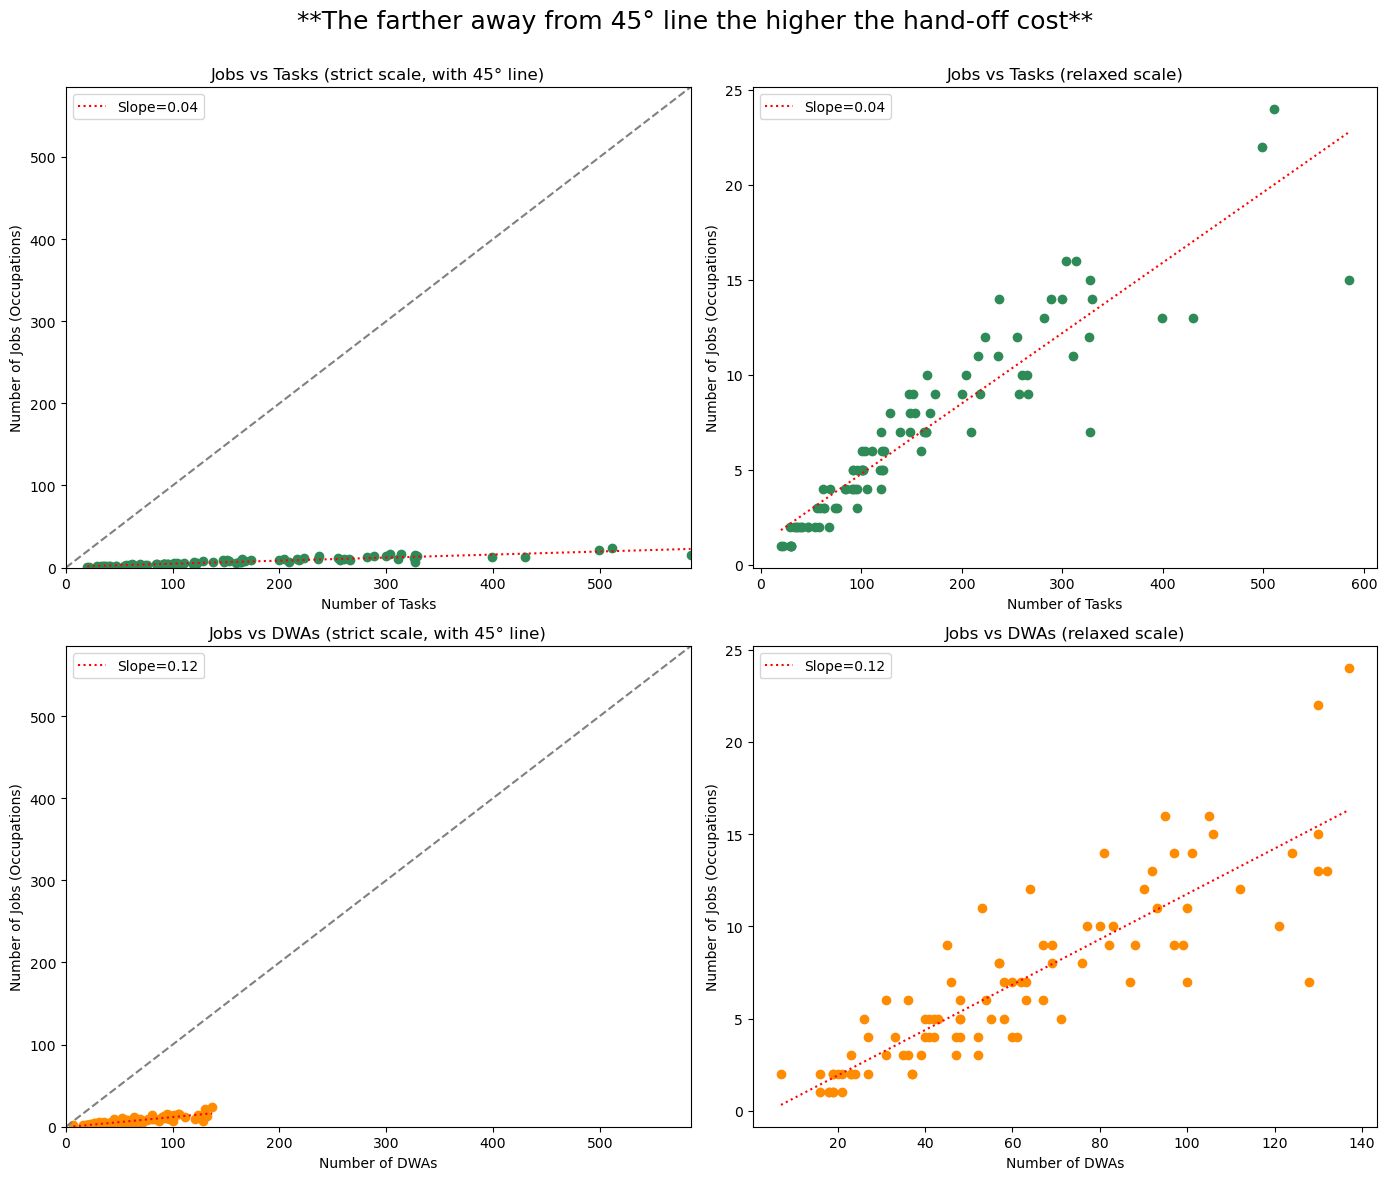

In [210]:
import matplotlib.pyplot as plt
import numpy as np

# --- Compute absolute counts per industry ---
jobs_tasks_abs = (
    onet.groupby("ind_name")
    .agg(
        num_unique_occ=("occ_title", "nunique"),
        num_unique_tasks=("task", "nunique"),
        num_unique_DWAs=("dwa_title", "nunique"),
        # num_unique_WAs=("wa_name", "nunique"),
    )
    .reset_index()
)

# Determine common axis limits for column 1 (strict)
max_x = jobs_tasks_abs["num_unique_occ"].max()
max_y = max(
    jobs_tasks_abs["num_unique_tasks"].max(),
    jobs_tasks_abs["num_unique_DWAs"].max(),
    # jobs_tasks_abs["num_unique_WAs"].max()
)
limit = max(max_x, max_y)

# --- Scatter plots in 3x2 grid ---
fig, axes = plt.subplots(2, 2, figsize=(14, 12), sharex=False, sharey=False)

# Data config
measures = [
    ("num_unique_tasks", "Tasks", "seagreen"),
    ("num_unique_DWAs", "DWAs", "darkorange"),
    # ("num_unique_WAs", "WAs", "purple"),
]

for i, (col, label, color) in enumerate(measures):
    x = jobs_tasks_abs[col].values
    y = jobs_tasks_abs["num_unique_occ"].values

    # Fit line (simple linear regression y = m*x + b)
    slope, intercept = np.polyfit(x, y, 1)

    # Print slope to console
    print(f"Slope for Jobs vs {label}: {slope:.3f}")

    # Generate fit line
    x_fit = np.linspace(x.min(), x.max(), 100)
    y_fit = slope * x_fit + intercept

    # Left column: strict axis with 45° line
    axes[i, 0].scatter(x, y, color=color)
    axes[i, 0].plot([0, limit], [0, limit], linestyle="--", color="gray")
    axes[i, 0].plot(x_fit, y_fit, linestyle=":", color="red", label=f"Slope={slope:.2f}")
    axes[i, 0].set_title(f"Jobs vs {label} (strict scale, with 45° line)")
    axes[i, 0].set_xlabel(f"Number of {label}")
    axes[i, 0].set_ylabel("Number of Jobs (Occupations)")
    axes[i, 0].set_xlim(0, limit)
    axes[i, 0].set_ylim(0, limit)
    axes[i, 0].legend()

    # Right column: relaxed axis (autoscale)
    axes[i, 1].scatter(x, y, color=color)
    axes[i, 1].plot(x_fit, y_fit, linestyle=":", color="red", label=f"Slope={slope:.2f}")
    axes[i, 1].set_title(f"Jobs vs {label} (relaxed scale)")
    axes[i, 1].set_xlabel(f"Number of {label}")
    axes[i, 1].set_ylabel("Number of Jobs (Occupations)")
    axes[i, 1].legend()

# Add super title on top of all subplots
fig.suptitle("**The farther away from 45° line the higher the hand-off cost**\n", fontsize=18)

plt.tight_layout()
plt.savefig(f"{output_plot_path}/jobs_vs_tasks_dwas_was_scatter_with_fit.png")
plt.show()